First import the multislice library, read in and plot the crystal and set up some basic parameters for our simulation

In [1]:
import py_multislice as ms
import numpy as np

import matplotlib.pyplot as plt

#Get crystal
crystal = ms.crystal('1000048.p1',temperature_factor_units='B')

#Quick plot of crystal
crystal.quickplot()

#Subslicing of crystal for multislice
subslices = [0.33,0.66,1.0]
nsubslices = len(subslices)

#Grid size in pixels
gridshape = [1024,1024]
tiling = [32,32]

#Size of real space grid
rsize = np.zeros((3,))
rsize[:3]  = crystal.unitcell[:3]
rsize[:2] *= np.asarray(tiling)

#Number of transmission functions
nT = 4

#Probe accelerating voltage in eV
eV = 3e5

#Probe forming aperture in mrad
app = 3 

#Number of frozen phonon passes
nfph = 25


<Figure size 640x480 with 1 Axes>

Set up and look at transmission functions

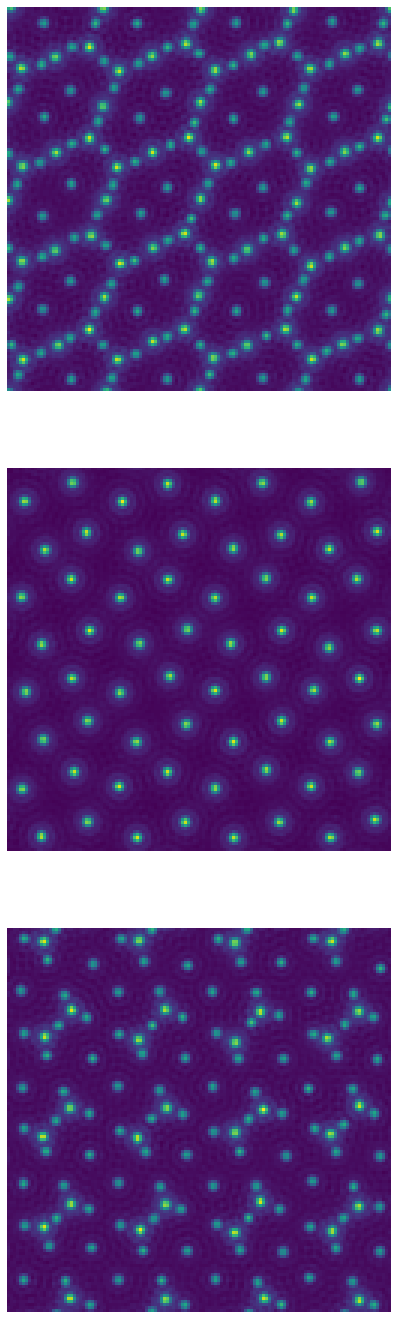

In [2]:
import torch
from torch_utils import cx_to_numpy


#Choose GPU if available CPU if not
if (torch.cuda.is_available()):
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

T = torch.zeros(nT,nsubslices,*gridshape,2,device=device)

for i in range(nT):
    T[i,:,:] = crystal.make_transmission_functions(gridshape,eV,subslices,tiling,fftout=True,device=device)

nrows = nsubslices
figsize = 8
fig,ax = plt.subplots(nrows=nrows,figsize=(figsize,figsize*nrows))
for i in range(nrows):
    ax[i].imshow(np.angle(cx_to_numpy(T[0,i,:gridshape[0]//tiling[0]*4,:gridshape[1]//tiling[1]*4])))
    ax[i].set_axis_off()

Now calculate CBED pattern and plot for a range of thicknesses

100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


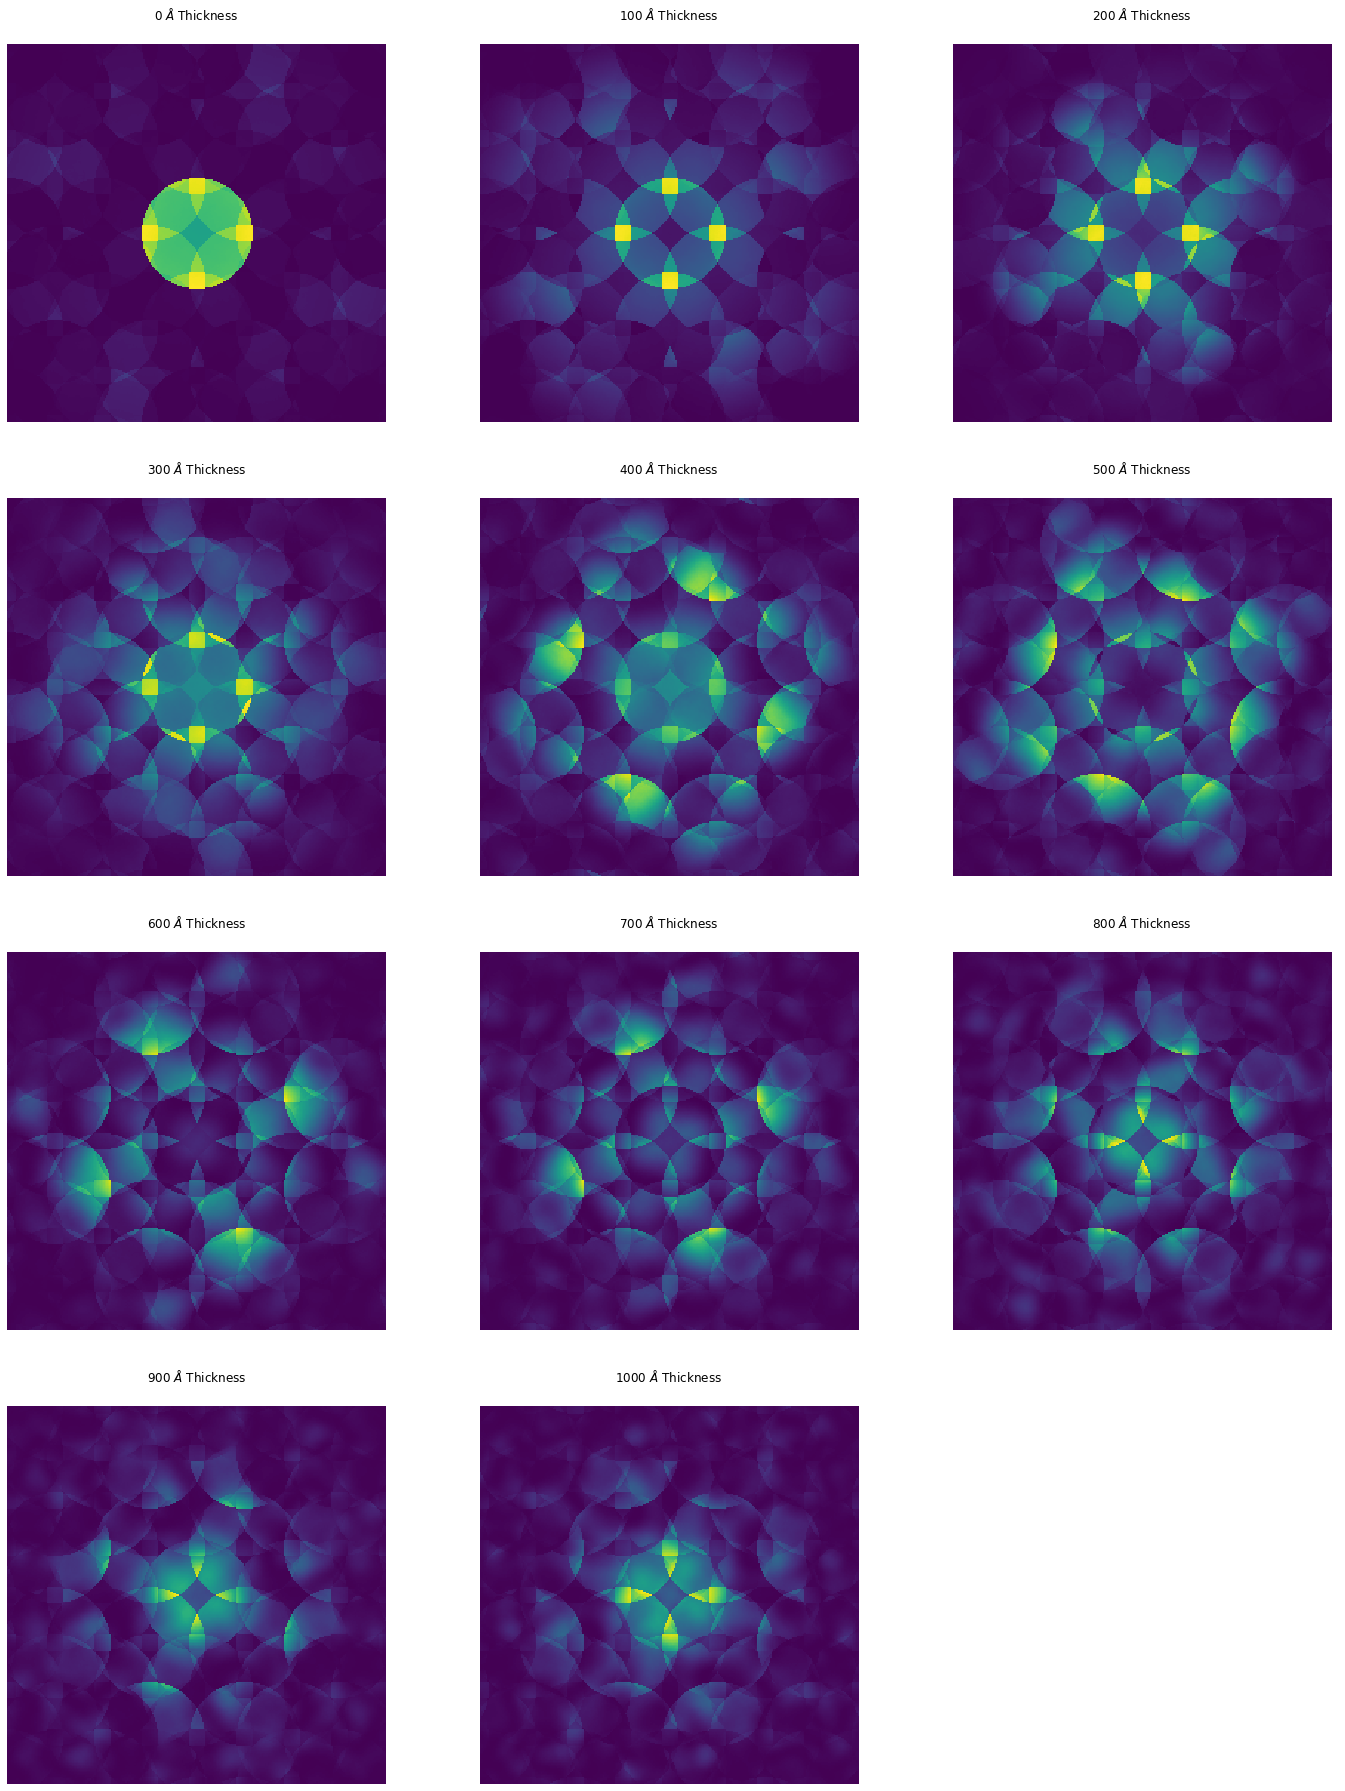

In [3]:
import Probe
from tqdm import tqdm


# Make Fresnel free-space propagators for multislice algorithm
propagators = ms.make_propagators(gridshape,rsize,eV,subslices)

# Set up thickness series
tstep = 100
thicknesses = np.arange(0,1001,tstep)
nt = thicknesses.shape[0]

nfph = 10

output = np.zeros((nt,*gridshape))
for ifph in tqdm(range(nfph)):
    #Make probe
    probe = Probe.construct_illum(gridshape,rsize,eV,app)

    for it,t in enumerate(thicknesses):
        probe = ms.multislice(probe,propagators,T,int(np.ceil(tstep/crystal.unitcell[2])),tiling=tiling)
        output[it,...] += np.abs(np.fft.fftshift(np.fft.fft2(probe)))**2

output/= nfph

#Set up montage to plot output
nn = int(np.ceil(np.sqrt(nt)))
figsize= 8
ncols = 3
nrows = int(np.ceil(nt/ncols))
fig,axes= plt.subplots(nrows=nrows,ncols=ncols,figsize=(figsize*ncols,figsize*nrows))

for i in range(nrows*ncols): axes[i//ncols,i%ncols].set_axis_off()        

def crop(array,outsize):
    insize = array.shape
    return array[(insize[0]-outsize[0])//2:(insize[0]+outsize[0])//2,
                 (insize[1]-outsize[1])//2:(insize[1]+outsize[1])//2]
    
for it,t in enumerate(thicknesses):
    ax = axes[it//ncols,it%ncols]
    ax.matshow(crop(output[it,...],[x//4 for x in gridshape]))
    ax.set_title('{0} $\\AA$ Thickness'.format(int(t)))
    

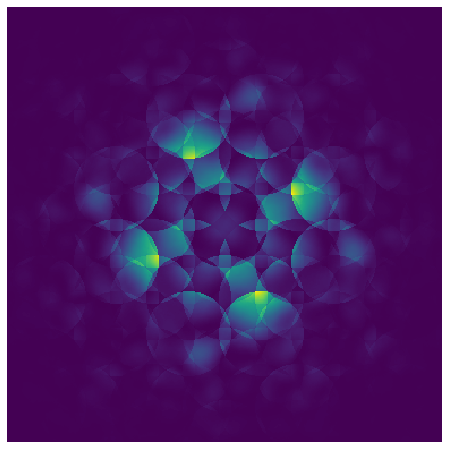

In [10]:
fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(crop(output[6,...],[3*x//8 for x in gridshape]))
ax.set_axis_off()
fig.savefig('cbed.png')